In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
ROOT_PATH = Path().resolve().parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import rcParams
from frequency_response import FrequencyResponse
from biquad import peaking, low_shelf, high_shelf, digital_coeffs

In [4]:
fns = {'PK': peaking, 'LS': low_shelf, 'HS': high_shelf}
fs = 48000
f = [20.0]
while f[-1] < fs:
    f.append(f[-1]*2**(1/32))
f = np.array(f)

def peq2fr(fc, q, gain, filts):
    if type(fc) != np.ndarray:
        fc = np.array([fc])
    if type(q) != np.ndarray:
        q = np.array([q])
    if type(gain) != np.ndarray:
        gain = np.array([gain])
    if type(filts) != np.ndarray:
        filts = np.array([filts])
    c = np.zeros(f.shape)
    for i, filt in enumerate(filts):
        a0, a1, a2, b0, b1, b2 = fns[filt](fc[i], q[i], gain[i], fs=fs)
        c += digital_coeffs(f, fs, a0, a1, a2, b0, b1, b2)
    fr = FrequencyResponse(name='PEG', frequency=f, raw=c)
    fr.interpolate()
    return fr

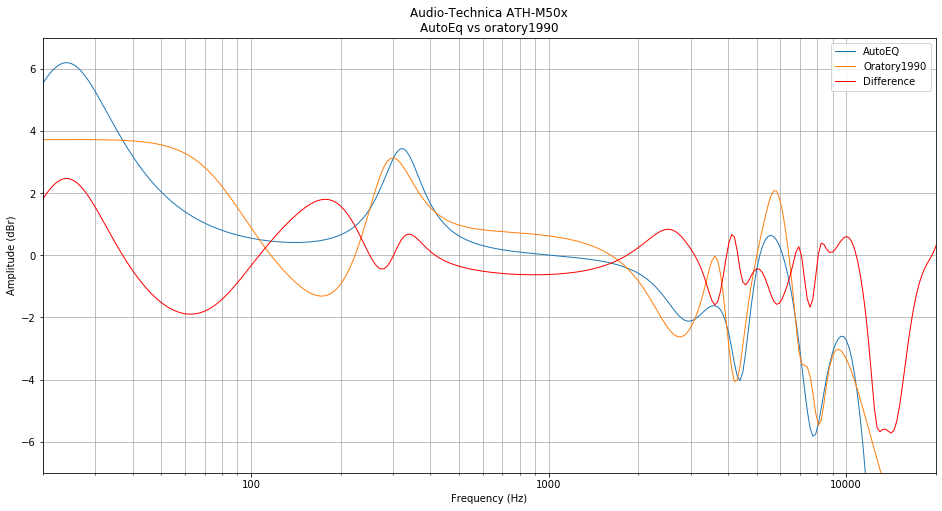

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

autoeq = peq2fr(
    [24, 322, 2947, 14388, 19893, 4419, 5501, 7712, 10169, 12622],
    [0.91, 2.34, 1.94, 1.35, 0.38, 4.45, 1.37, 3.23, 1.9, 4.29],
    [6.2, 3.4, -2.2, -9.1, -8.0, -5.0, 3.5, -5.7, 2.8, -3.2],
    ['PK'] * 10
)

oratory1990 = peq2fr(
    [90, 200, 290, 2800, 3670, 4240, 5800, 7000, 8100, 11000],
    [0.9, 0.9, 1.8, 1.5, 4.5, 4.5, 3.5, 6.0, 5.0, 0.8],
    [2.8, -3.3, 4.5, -3.7, 2.7, -5.0, 2.8, -3.0, -4.6, -10.0],
    ['LS'] + ['PK'] * 8 + ['HS'],
)

diff = FrequencyResponse(name='diff', frequency=f, raw=autoeq.raw - oratory1990.raw)
delta = np.mean(diff.raw[np.logical_and(f >= 100, f <= 10000)])
oratory1990.raw += delta
diff.raw = autoeq.raw - oratory1990.raw

autoeq.plot_graph(fig=fig, ax=ax, show=False, color='C0')
oratory1990.plot_graph(fig=fig, ax=ax, show=False, color='C1')
diff.plot_graph(fig=fig, ax=ax, show=False, color='red')

ax.legend(['AutoEQ', 'Oratory1990', 'Difference'])
ax.set_ylim([-7, 7])
ax.set_title('Audio-Technica ATH-M50x\nAutoEq vs oratory1990')
plt.savefig('Audio-Technica ATH-M50x.png')
plt.show()


No handles with labels found to put in legend.


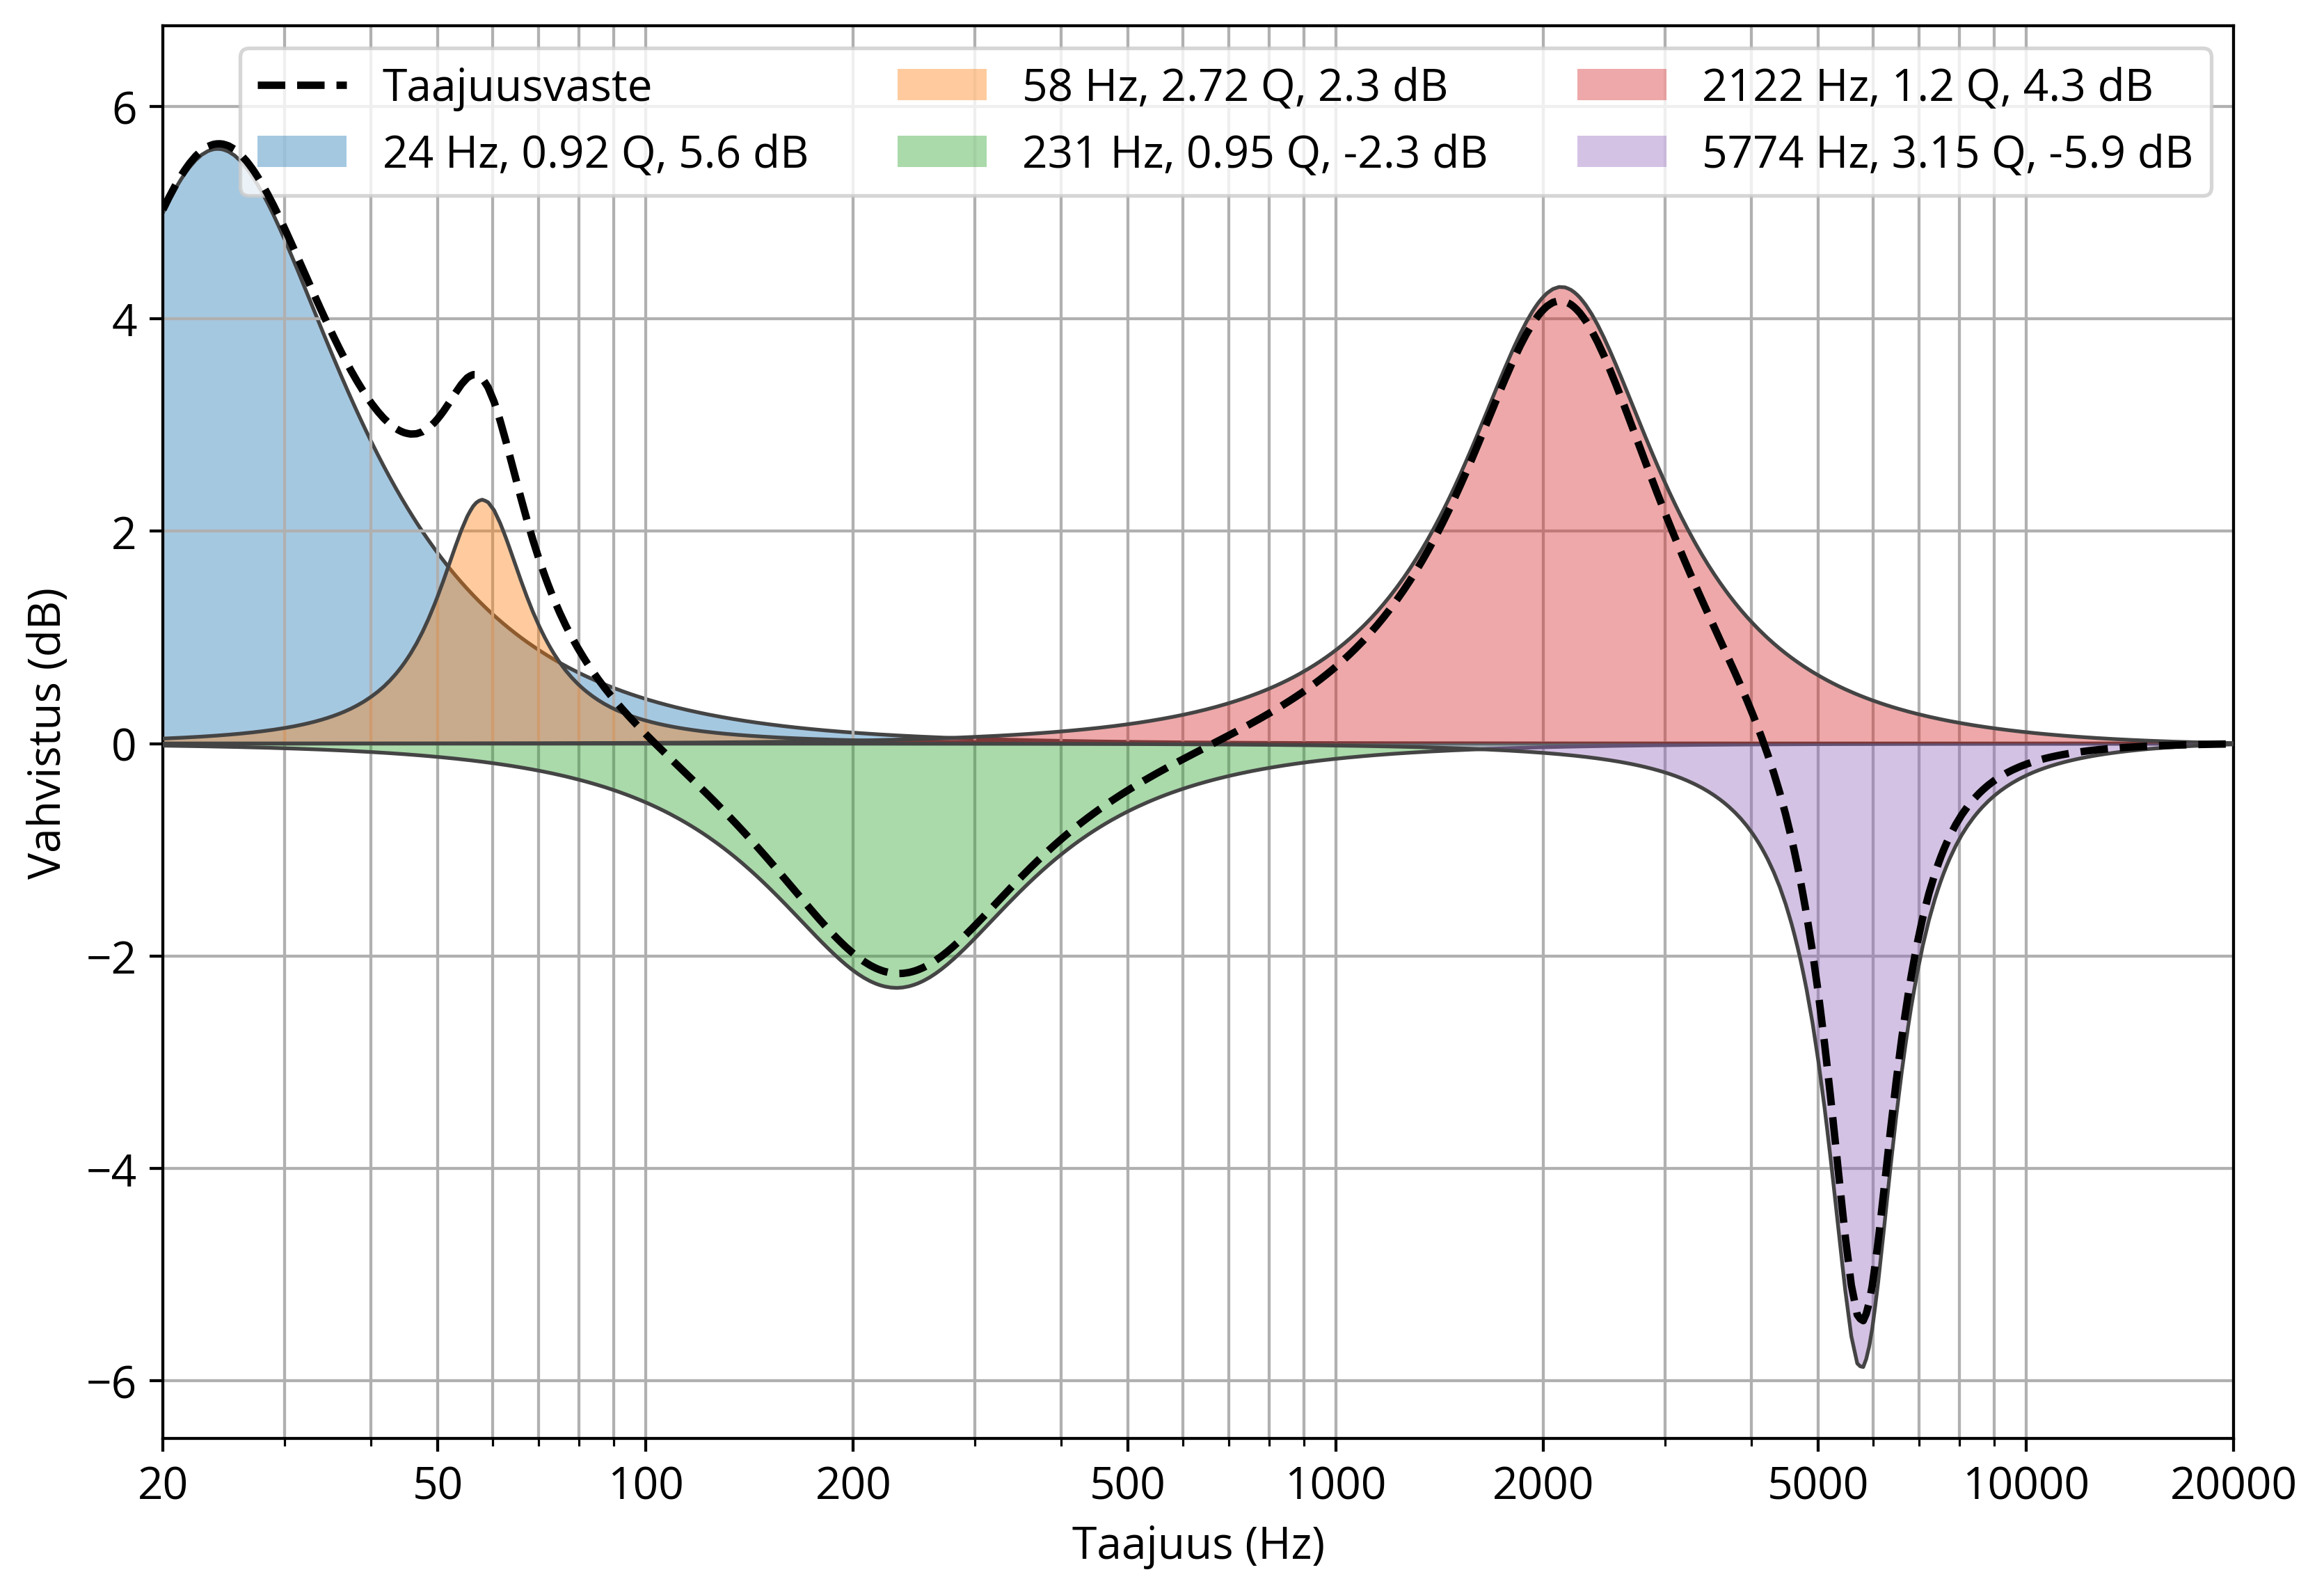

In [7]:
fc = [24, 58, 231, 2122, 5774]
q = [0.92, 2.72, 0.95, 1.2, 3.15]
gain = [5.6, 2.3, -2.3, 4.3, -5.9]

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Open Sans']
rcParams['font.size'] = 12
rcParams['figure.dpi'] = 384
fig = None
ax = None
#fig, ax = plt.subplots()
i = 0
frs = []
for _fc, _q, _gain in zip(fc, q, gain):
    fr = peq2fr(_fc, _q, _gain, 'PK')
    frs.append(fr)
    fig, ax = fr.plot_graph(fig=fig, ax=ax, raw_plot_kwargs={'color': '#444444', 'zorder': i*2+1, 'label': None}, show=False)
    label = f'Fc={_fc:.0f} Hz, Q={_q}, Gain={_gain:.1f} dB'
    label = f'{_fc:.0f} Hz, {_q} Q, {_gain:.1f} dB'
    ax.fill_between(fr.frequency, fr.raw, alpha=0.4, zorder=i*2, label=label)
    i += 1
fr = FrequencyResponse(name='Parametric equalizer', frequency=frs[0].frequency, raw=np.sum([_fr.raw for _fr in frs], axis=0))
fr.plot_graph(fig=fig, ax=ax, raw_plot_kwargs={'color': 'black', 'zorder': 11, 'label': 'Taajuusvaste', 'linewidth': 2, 'linestyle': 'dashed'}, show=False)

ymin = np.min(fr.raw)
ymax = np.max(fr.raw)
ydelta = ymax - ymin
ymin -= 0.1 * ydelta
ymax += 0.1 * ydelta
ax.set_ylim([ymin, ymax])
ax.legend(ncol=3)
#ax.grid(False, which='both')
ax.set_title('')
ax.set_xlabel('Taajuus (Hz)')
ax.set_ylabel('Vahvistus (dB)')
ax.set_xticks([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000])
fig.set_size_inches(10, 7)
fig.savefig('peq.png', bbox_inches='tight')
plt.show()